# 

# Focused on indervidual events

Looking at single events, drawn from the G4 data, and produced by a model.

Viewing events produced by the model is mostly a sanity check.

## Start with imports and configs

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

from pointcloud.config_varients.bug_dip import Configs

from pointcloud.data.read_write import read_raw_regaxes, get_n_events
from pointcloud.utils.gen_utils import gen_cond_showers_batch
from pointcloud.evaluation.bin_standard_metrics import sample_model, get_caloclouds_models

import os

def try_mkdir(dir_name):
    try:
        os.mkdir(dir_name)
    except FileExistsError:
        pass

%matplotlib widget


#%run visulise_data.py
configs = Configs()


try:
    configs.device = "cuda"
    incident_energies = torch.linspace(0.1, 1.0, 5)[:, None].to(configs.device)
except Exception as e:
    configs.device = "cpu"
    incident_energies = torch.linspace(0.1, 1.0, 5)[:, None].to(configs.device)
configs.poly_degree = 1
#configs.dataset_path_in_storage = False
#configs.dataset_path = "../../../point-cloud-diffusion-data/even_batch_10k.h5"
#configs.dataset_path = "../../../data_production/ILCsoftEvents/p22_r0_th90_ph90_en10-90_downsampled.h5"
#configs.dataset_path = "/home/dayhallh/Data/p22_th90_ph90_en10-100_joined/p22_th90_ph90_en10-100_seed42_all_steps.hdf5"
#configs.dataset_path_in_storage = True
#configs._dataset_path = defaults._dataset_path

Grab some random events and plot one with a function from elsewhere.

## Custom plot function

We actually need fixed axes lengths to compare data easly.
Because all our data has different scales on, it's easier to have a plot function that lets us rescale on the fly.

Also define a way to plot the output of a model at specified incident energy.


In [2]:


def plot_event(event_n, energy_in, use_event, energy_scale=1, x_scale=1, ax=None, flat=False):
    energy = use_event[:, 3]
    mask = energy>0
    n_points = sum(mask)
    energy = energy[mask] * energy_scale
    xs = use_event[mask, 0] * x_scale
    ys = use_event[mask, 1] * x_scale
    zs = use_event[mask, 2] 
    if ax is None:
        fig = plt.figure()
        if flat:
            ax = fig.add_subplot(111)
        else:
            ax = fig.add_subplot(111, projection='3d')
    if flat:   
        ax.scatter(ys, zs, c=np.log(energy), s=energy, cmap='viridis')
    else:
        ax.scatter(xs, ys, zs, c=np.log(energy), s=energy, cmap='viridis')
        ax.set_zlabel('z')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    #ax.set_xlim(-150, 150)
    #ax.set_ylim(-150, 150)
    # write a title
    observed_energy = energy.sum()
    ax.set_title(f'Evt: {event_n}, $n_{{pts}}$: {n_points},\n $E_{{in}}$: {energy_in:.2f}, $E_{{vis}}$: {observed_energy:.2f}')

def plot_wish_model(energy_in, model, ax=None, flat=False):
    xs, ys, zs, es = model.inference(energy_in)
    event = np.empty((len(xs), 4))
    event[:, 0] = xs
    event[:, 1] = ys
    event[:, 2] = zs
    event[:, 3] = es
    plot_event("Modeled", energy_in, event, energy_scale=1., x_scale=150, ax=ax, flat=flat)


### G4

Quickly plot a few G4 events. Shows some expected behavior.

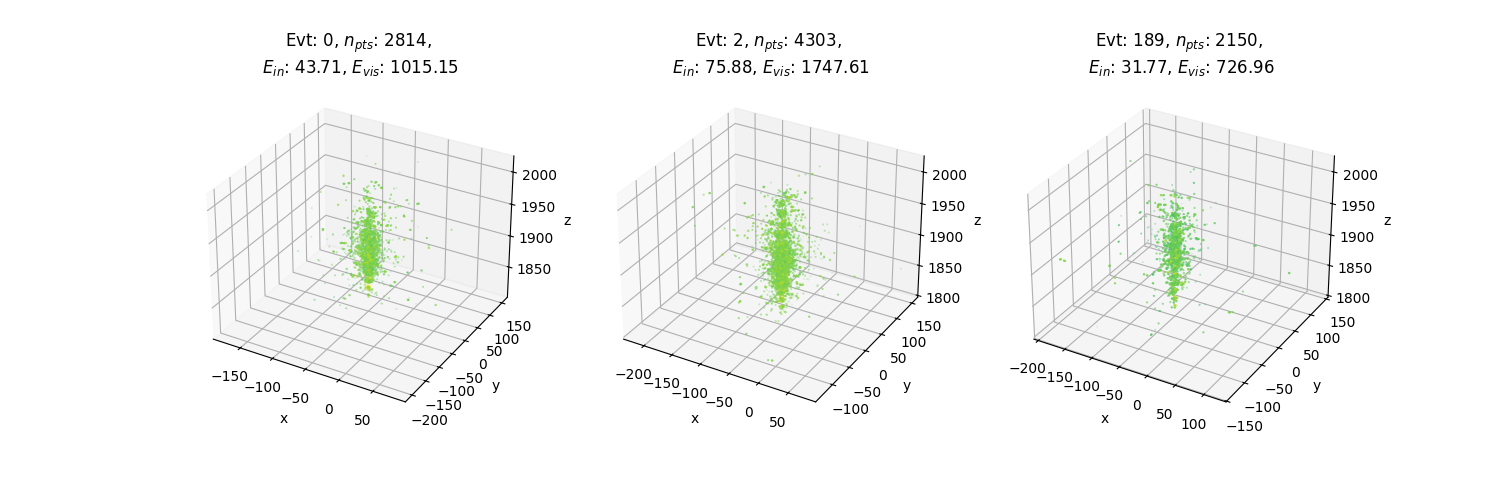

In [3]:
# high anomaly
fig = plt.figure(figsize=(15, 5))
use_events = [0, 2, 189]
energies, events = read_raw_regaxes(configs, use_events)
for i, event_n in enumerate(use_events):
    ax = fig.add_subplot(131+i, projection='3d')
    
    energy_in = energies[i]
    use_event = events[i]
    plot_event(event_n, energy_in, use_event, energy_scale=1000, ax=ax)


### Wish

Plot those same energies from the model.

In [4]:
from pointcloud.models.wish import Wish, load_wish_from_accumulator

if False:
    #wish_path = "../../../point-cloud-diffusion-logs/wish/dataset_accumulators/10-90GeV_x36_grid_regular_524k_float32/wish_from_10.pt"
    wish_path = "../../../point-cloud-diffusion-logs/wish/dataset_accumulators/p22_th90_ph90_en10-1/wish_poly1.pt"
    accumulator_path = "../../../point-cloud-diffusion-logs/wish/dataset_accumulators/p22_th90_ph90_en10-100_accumulator.h5"
    # acaccumulator_path = "../../../point-cloud-diffusion-logs/wish/dataset_accumulators/10-90GeV_x36_grid_regular_524k_float32/from_10_0p25.h5"
    
    configs.fit_attempts = 3
    wish_model = Wish(configs)
    #wish_model = load_wish_from_accumulator(accumulator_path)
    #wish_model.save(wish_path)
    wish_model = Wish.load(wish_path)
    
    fig = plt.figure(figsize=(15, 5))
    for i, e in enumerate([10, 50, 90]):
        ax = fig.add_subplot(131+i, projection='3d')
        plot_wish_model(e, wish_model, ax=ax)

/data/dust/user/dayhallh/point-cloud-diffusion-logs/investigation2/CD_2024_12_11__14_32_19/ckpt_0.435745_170000.pt
original_nb4_fnorms has best loss -126.50459164989238
Found 1 saved models
/data/dust/user/dayhallh/point-cloud-diffusion-data/investigation2/showerFlow/10-90GeV_x36_grid_regular_524k_float32_10k/ShowerFlow_original_nb6_inputs36893488147419103231_fnorms_best.pth
/data/dust/user/dayhallh/duncan/gen0/ckpt_0.465886_560000.pt
original_nb4_fnorms has best loss -126.50459164989238
Found 1 saved models
/data/dust/user/dayhallh/point-cloud-diffusion-data/investigation2/showerFlow/10-90GeV_x36_grid_regular_524k_float32_10k/ShowerFlow_original_nb6_inputs36893488147419103231_fnorms_best.pth
/data/dust/user/dayhallh/point-cloud-diffusion-logs/investigation2/CD_2024_12_11__14_32_19/ckpt_0.435745_170000.pt
original_nb4_fnorms has best loss -126.50459164989238
Found 1 saved models
/data/dust/user/dayhallh/duncan/gen0/ShowerFlow_alt1_nb4_inputs36893488147419103231_best.pth
/data/dust/user

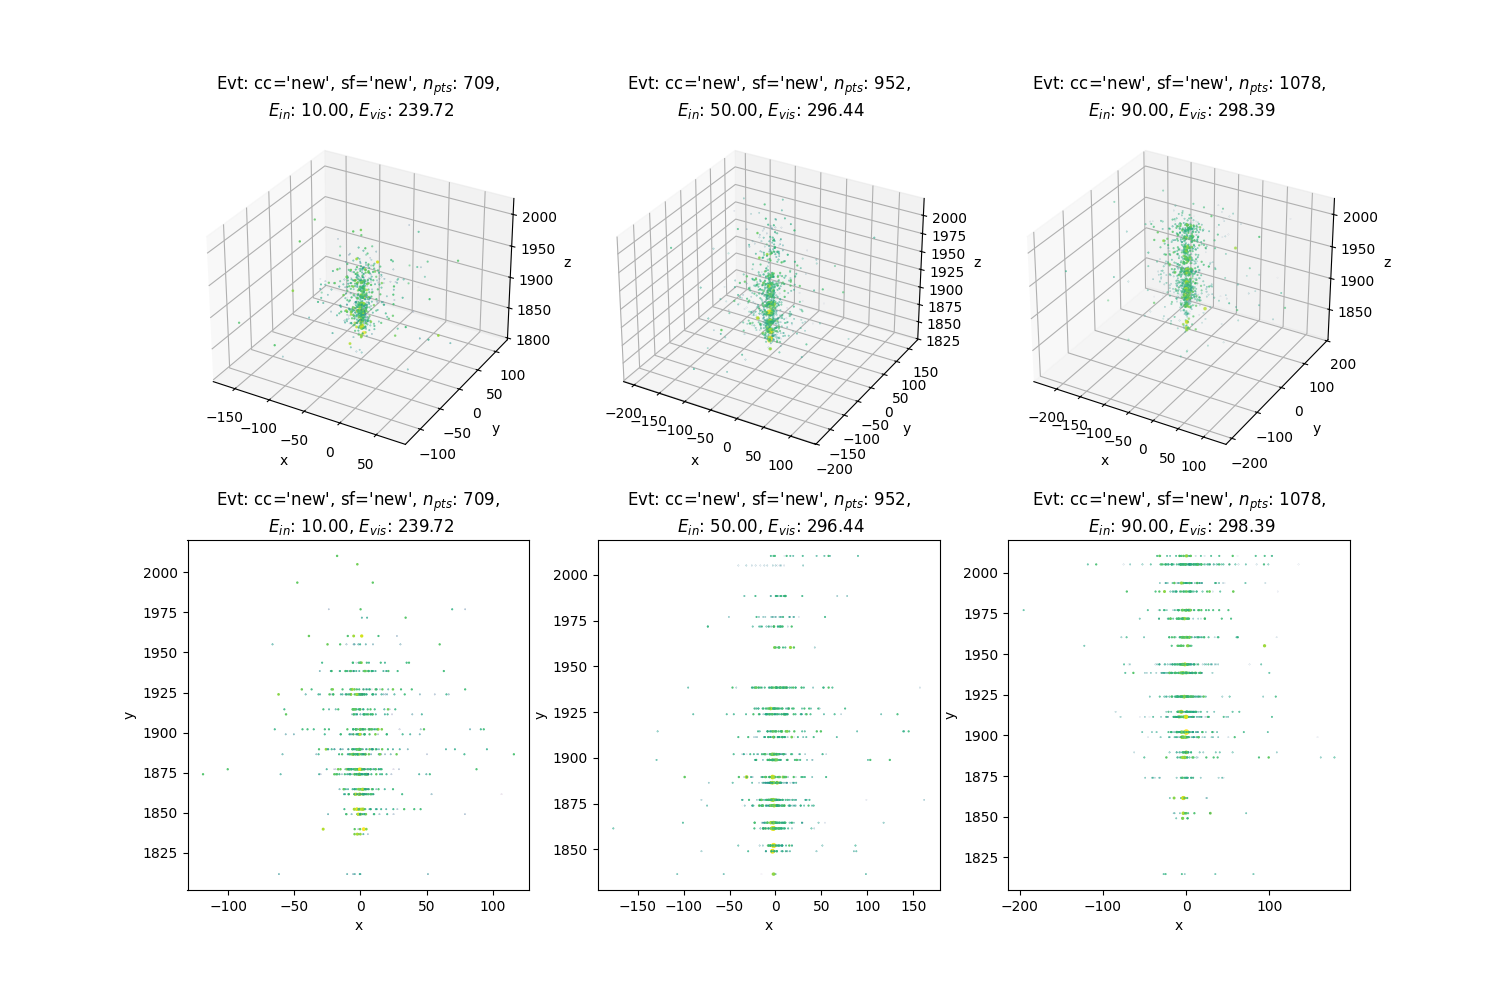

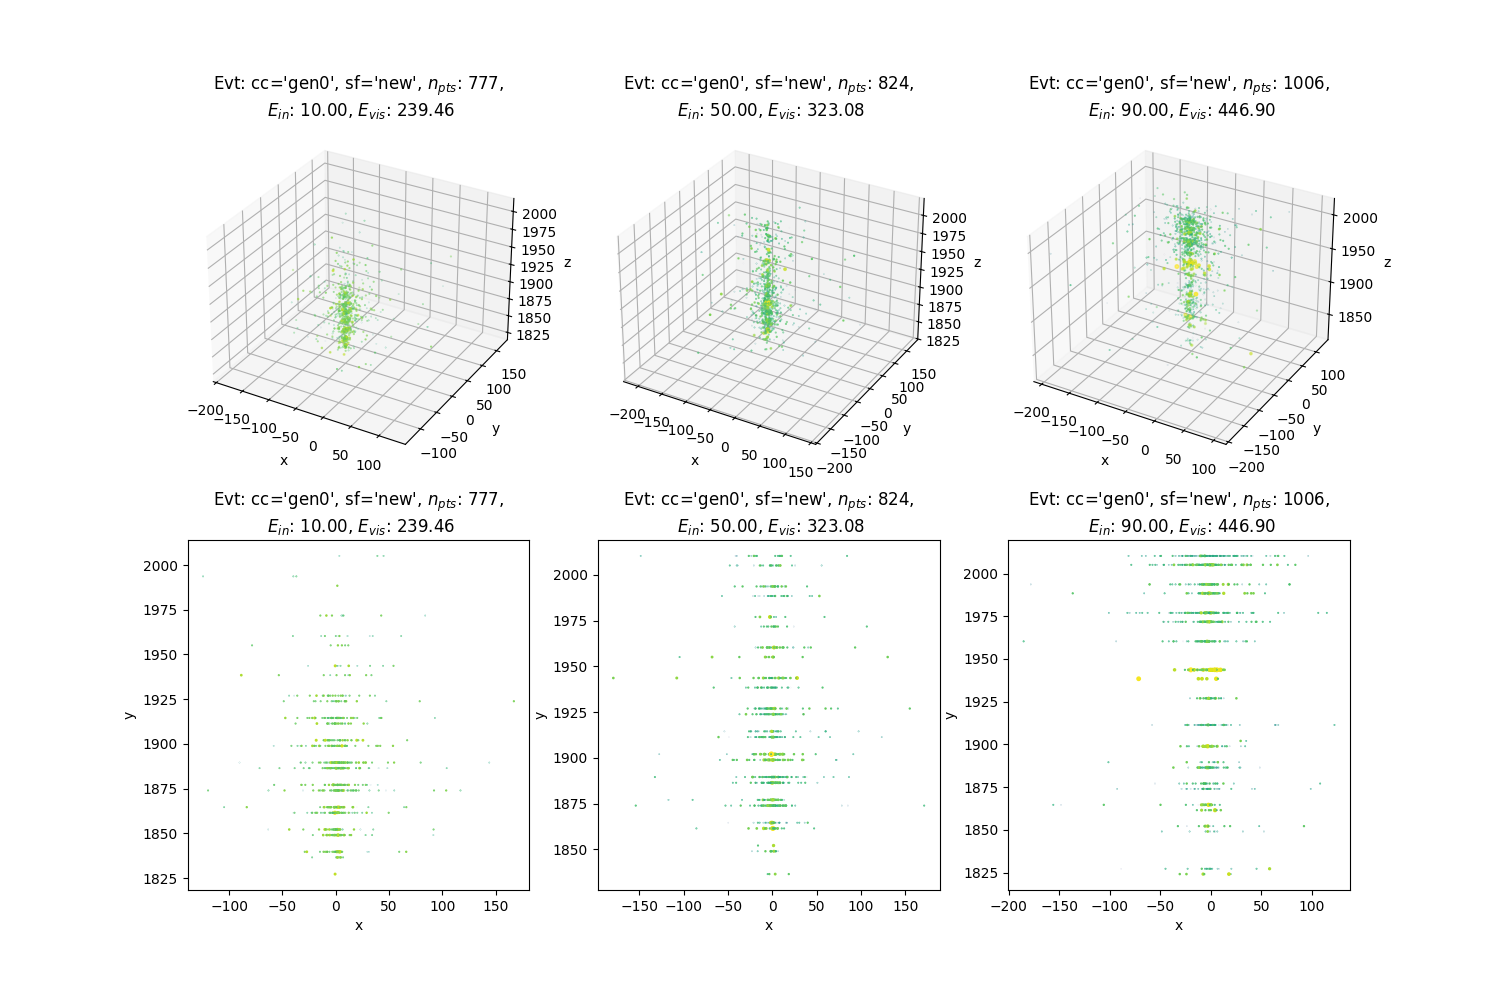

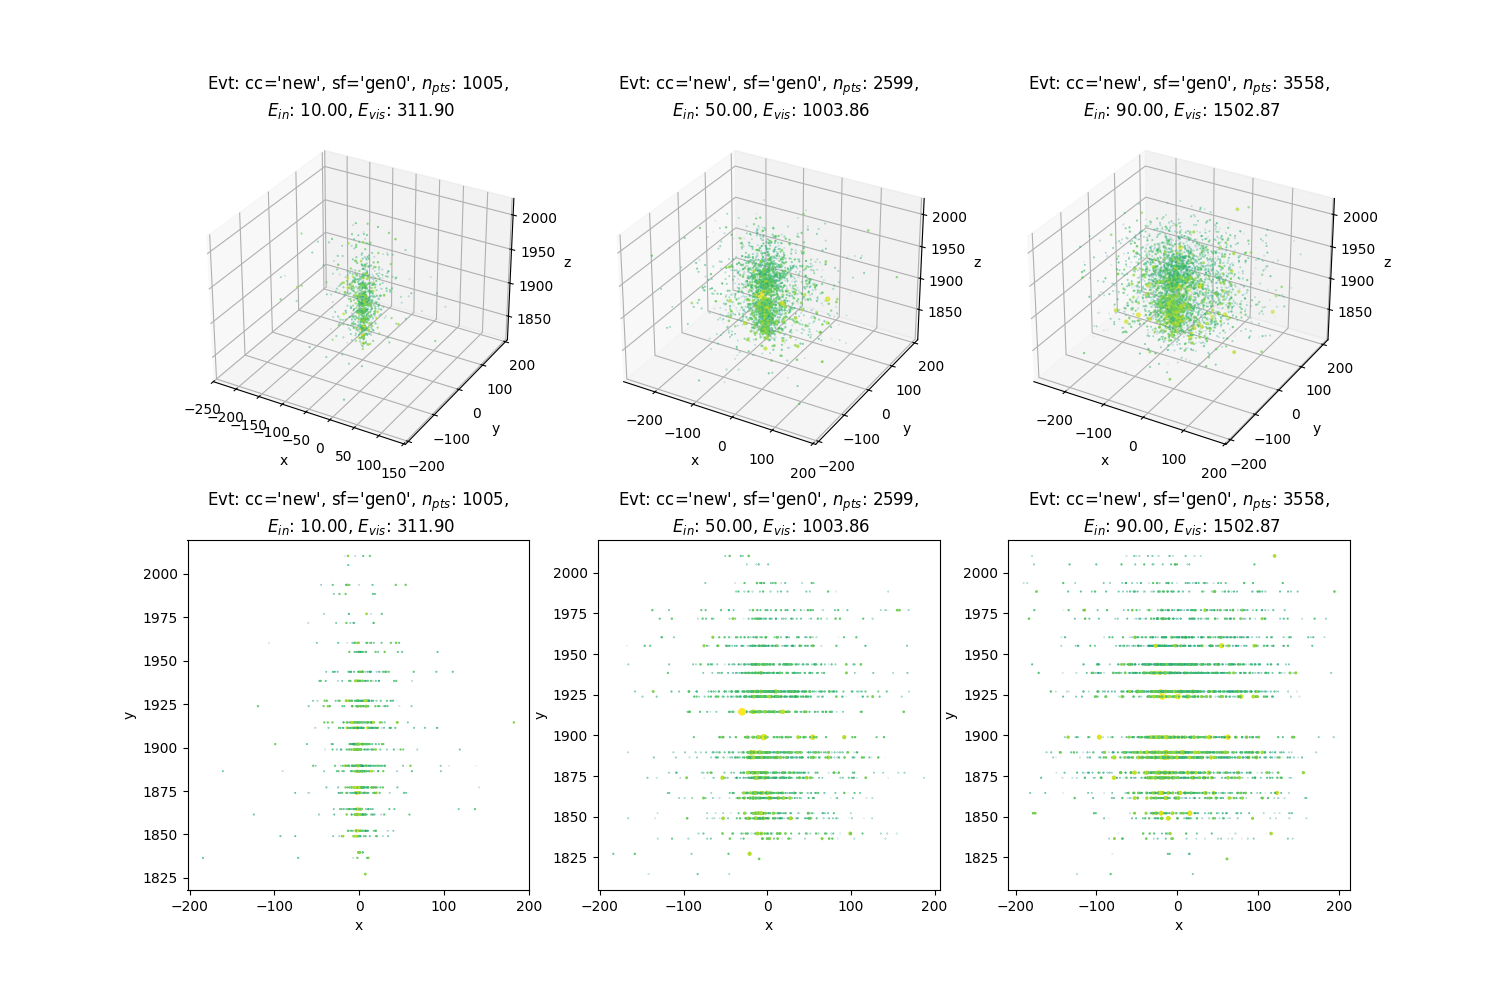

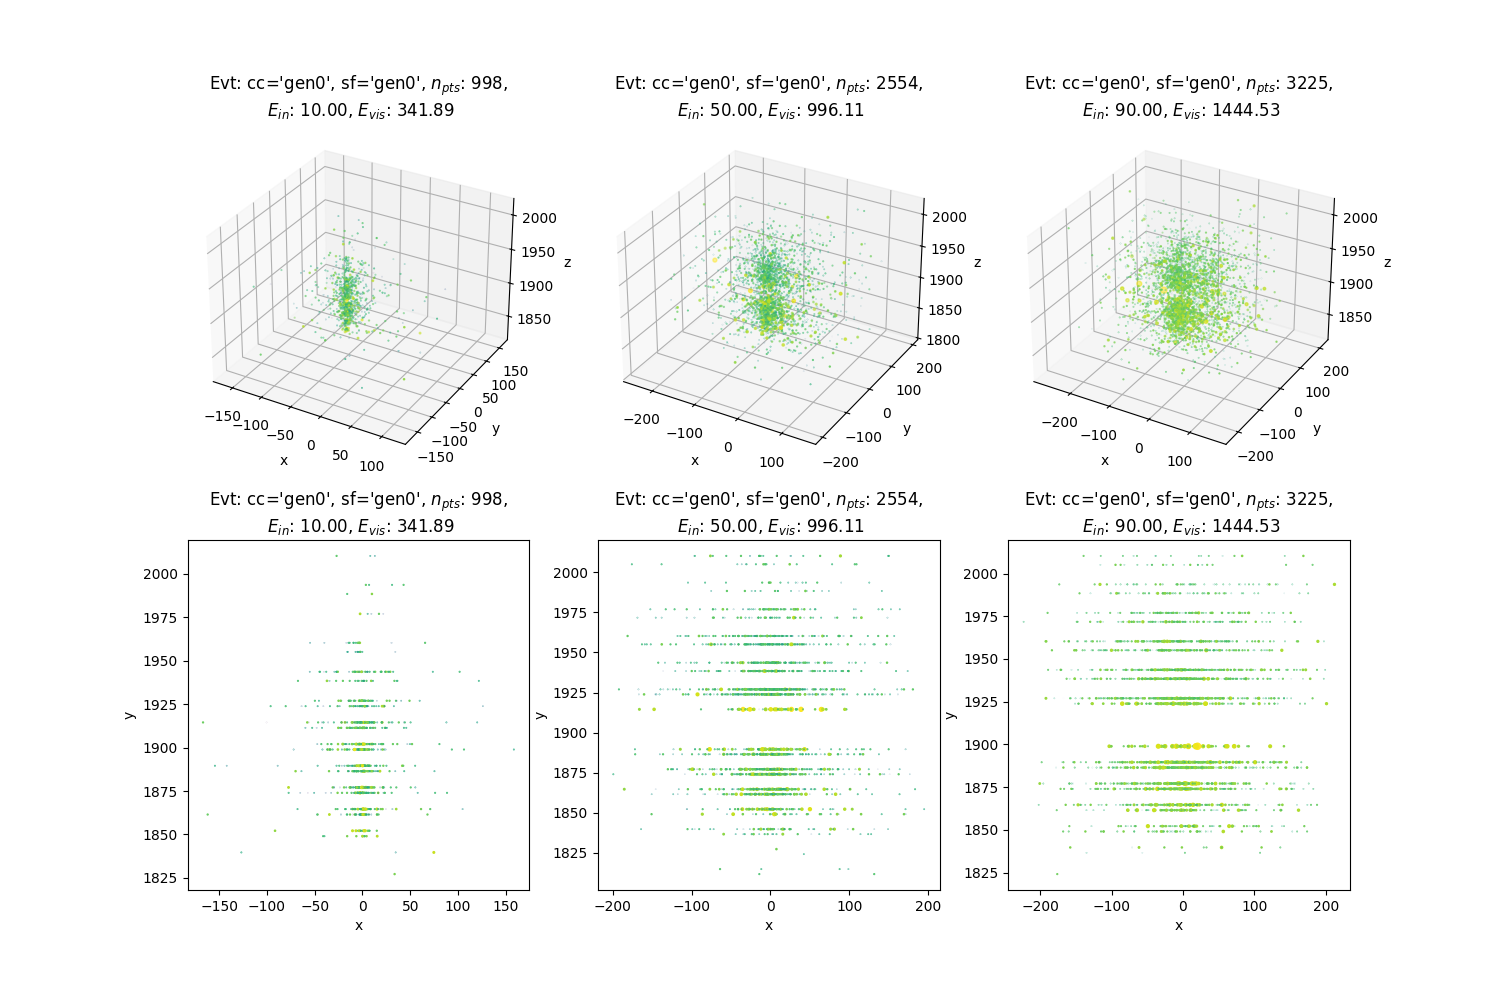

In [5]:
caloclouds = "/data/dust/user/dayhallh/duncan/gen0/ckpt_0.465886_560000.pt"
showerflow = "/data/dust/user/dayhallh/duncan/gen0/ShowerFlow_alt1_nb4_inputs36893488147419103231_best.pth"
new_caloclouds = "/data/dust/user/dayhallh/point-cloud-diffusion-logs/investigation2/CD_2024_12_11__14_32_19/ckpt_0.435745_170000.pt"
new_showerflow = "/data/dust/user/dayhallh/point-cloud-diffusion-data/investigation2/showerFlow/10-90GeV_x36_grid_regular_524k_float32_10k/ShowerFlow_original_nb6_inputs36893488147419103231_fnorms_best.pth"
cond = torch.tensor([10, 50, 90])[None, :].T

for sf in ["new", "gen0"]:
    sf_path = showerflow if sf == "gen0" else new_showerflow
    for cc in ["new", "gen0"]:
        cc_path = caloclouds if cc == "gen0" else new_caloclouds

        cc_model, dist, showerflow_configs = get_caloclouds_models(caloclouds_paths=cc_path, showerflow_paths=sf_path, configs=configs)["CaloClouds3"]
        batch = gen_cond_showers_batch(cc_model, dist, cond, config=showerflow_configs)



        fig = plt.figure(figsize=(15, 10))
        for i, e in enumerate(cond.detach().flatten()):
            ax = fig.add_subplot(231+i, projection='3d')
            plot_event(f"{cc=}, {sf=}", e, batch[i], ax=ax)
        for i, e in enumerate(cond.detach().flatten()):
            ax = fig.add_subplot(234+i)
            plot_event(f"{cc=}, {sf=}", e, batch[i], ax=ax, flat=True)

